In [1]:
#learn about Pandas and Numpy from www.w3schools.com. Do the tutorials.
#
#Pandas - https://www.w3schools.com/python/pandas/default.asp
#       - Pandas is used to analyze data.
#
#Numpy  - https://www.w3schools.com/python/numpy/default.asp
#       - NumPy is used for working with arrays.
#       - NumPy is short for "Numerical Python".
#


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum, auto

In [2]:
THEO_COLUMNS = ['theo_event_tx_timestamp', 'theo_event_tx_timestamp_ns',
                'instrument_hash','tv','delta','vol','vega','under','tte',
                'option_type_name','inst_type_name','strike','term']

In [3]:
data = pd.read_csv('DeltaHedgingData.csv') # 22 and 23 concatenated
data_22 = pd.read_csv('DeltaHedgingData_20230522.csv') # Train
data_23 = pd.read_csv('DeltaHedgingData_20230523.csv') # Test

In [4]:
# Concatenate the train (22nd) and test (23rd) data
concatenated_data = pd.concat([data_22, data_23], ignore_index=True)

# Check if the concatenated data matches the 'data' DataFrame
# Method 1: Check if they are exactly identical
are_identical = concatenated_data.equals(data)
print("Is data and 22+23 identical?", are_identical)

Is data and 22+23 identical? True


In [5]:
data.head()

,theo_event_tx_timestamp,trade_date,option_type_name,term,strike,tv,delta,gamma,under,tte,vega
0,2023-05-22 11:55:02.407195,2023-05-22,PUT,Jun-2023,26.22,0.987344,-0.538346,0.191068,25.800806,0.075243,2.810530
1,2023-05-22 12:00:15.409357,2023-05-22,PUT,Jun-2023,26.22,0.987280,-0.538348,0.191084,25.800806,0.075232,2.810316
2,2023-05-22 12:01:17.787593,2023-05-22,PUT,Jun-2023,26.22,0.987276,-0.538348,0.191085,25.800806,0.075231,2.810300
3,2023-05-22 12:15:15.408862,2023-05-22,PUT,Jun-2023,26.22,0.987216,-0.538350,0.191099,25.800806,0.075220,2.810101
4,2023-05-22 12:30:15.408916,2023-05-22,PUT,Jun-2023,26.22,0.987153,-0.538352,0.191115,25.800806,0.075209,2.809887


In [6]:
data.shape

(117845, 11)

In [7]:
data_22.head()

,theo_event_tx_timestamp,trade_date,option_type_name,term,strike,tv,delta,gamma,under,tte,vega
0,2023-05-22 11:55:02.407195,2023-05-22,PUT,Jun-2023,26.22,0.987344,-0.538346,0.191068,25.800806,0.075243,2.810530
1,2023-05-22 12:00:15.409357,2023-05-22,PUT,Jun-2023,26.22,0.987280,-0.538348,0.191084,25.800806,0.075232,2.810316
2,2023-05-22 12:01:17.787593,2023-05-22,PUT,Jun-2023,26.22,0.987276,-0.538348,0.191085,25.800806,0.075231,2.810300
3,2023-05-22 12:15:15.408862,2023-05-22,PUT,Jun-2023,26.22,0.987216,-0.538350,0.191099,25.800806,0.075220,2.810101
4,2023-05-22 12:30:15.408916,2023-05-22,PUT,Jun-2023,26.22,0.987153,-0.538352,0.191115,25.800806,0.075209,2.809887


In [8]:
data_22.shape

(57028, 11)

In [9]:
data_23.head()

,theo_event_tx_timestamp,trade_date,option_type_name,term,strike,tv,delta,gamma,under,tte,vega
0,2023-05-23 11:55:02.253508,2023-05-23,PUT,Jun-2023,26.22,0.995743,-0.568129,0.220193,25.653493,0.071390,2.695738
1,2023-05-23 11:59:49.436854,2023-05-23,PUT,Jun-2023,26.22,0.995721,-0.568132,0.220200,25.653493,0.071386,2.695657
2,2023-05-23 12:09:19.551075,2023-05-23,PUT,Jun-2023,26.22,0.995682,-0.568136,0.220211,25.653493,0.071379,2.695516
3,2023-05-23 12:24:19.550555,2023-05-23,PUT,Jun-2023,26.22,0.995621,-0.568142,0.220230,25.653493,0.071367,2.695294
4,2023-05-23 12:30:02.075644,2023-05-23,PUT,Jun-2023,26.22,0.996184,-0.568371,0.220245,25.652463,0.071363,2.694865


In [10]:
data_23.shape

(60817, 11)

## Sanity Checks

In [11]:
# Consistency of dates
data['trade_date'] = pd.to_datetime(data['trade_date'])
data['theo_event_tx_timestamp'] = pd.to_datetime(data['theo_event_tx_timestamp'])
assert (data['trade_date'].dt.date == data['theo_event_tx_timestamp'].dt.date).all(), "Inconsistent dates"

In [12]:
# Checking the range of delta, gamma
assert (data['delta'] < 0).all(), "Put option delta should be negative"
assert (data['gamma'] > 0).all(), "Gamma should be positive"

In [13]:
assert not data.isnull().values.any(), "There are missing values in the data"

In [14]:
assert(data_22.shape[0] + data_23.shape[0] == data.shape[0])

## Frequency and Hedger Classes (Slightly modified from original)

In [15]:
class Frequency(str, Enum):
    SNAP = 'snap'
    MINUTE = 'minute'
    HOURLY = 'hour'
    DAILY = 'daily'
    DELTA_THRESHOLD = 'DELTA_THRESHOLD'

In [16]:
class Hedger:

    def __init__(self,
                 data: pd.DataFrame,
                 t_cost: float = 5.0,
                 open_time: str = '13:05',
                 close_time: str = '19:50',
                 # in basis point
                 ):

        self.data = data.copy()
        self.t_cost = t_cost
        self.open_time = open_time
        self.close_time = close_time
        self.prepare_data()

    def prepare_data(self):
        self.data.set_index(pd.DatetimeIndex(self.data['theo_event_tx_timestamp']), inplace=True)
        self.data.sort_index(inplace=True)
        self.data = self.data.between_time(self.open_time, self.close_time)
        self.data['id'] = range(self.data.shape[0])

    def tag_hedge_flags(self, frequency: Frequency, delta_threshold=None):
        if frequency == Frequency.SNAP:
            self.data['hedge_flag'] = True
        elif frequency == Frequency.DELTA_THRESHOLD: # Hedge if cumulative delta since last trade reaches a threshold
            self.tag_delta_threshold_hedge(delta_threshold)
        else:
            if frequency == Frequency.MINUTE:
                grouper = pd.to_datetime(self.data.index).floor("min")
            elif frequency == Frequency.HOURLY:
                grouper = pd.to_datetime(self.data.index).floor("h")
            elif frequency == Frequency.DAILY:
                grouper = pd.to_datetime(self.data.index).date
            self.data['hedge_flag'] = self.data.groupby(grouper)['id'].transform('last') == self.data.id

    def calculate_net_cashflow(self, prev_delta, new_delta, under):
        diff_delta = new_delta - prev_delta 
        fee = np.abs(diff_delta) * under * self.t_cost / 1e4
        return -diff_delta * under - fee
        
    def incurred_fee(self, prev_delta, new_delta, under):
        diff_delta = new_delta - prev_delta
        return -np.abs(diff_delta) * under * self.t_cost / 1e4
    
    def net_portfolio_value(self, tv, under, under_quantity, net_cash_flow):
        return tv + under_quantity * under + net_cash_flow


    # Added function - Alexander
    def tag_delta_threshold_hedge(self, delta_threshold):
        self.data['hedge_flag'] = False
        prev_traded_delta = 0
        net_delta_change = 0
        
        for i, row in self.data.iterrows():
            delta_change = row['delta'] - prev_traded_delta
            net_delta_change = delta_change
            
            if abs(net_delta_change) >= delta_threshold:
                self.data.at[i, 'hedge_flag'] = True
                prev_traded_delta = row['delta']  # Update the traded delta to the current delta
                net_delta_change = 0  # Reset cumulative delta change after hedging
                
    def mtm(self, tv, under, under_quantity):
        return tv + under_quantity * under

    
    
    def time_based_calculate(self, frequency: Frequency, delta_threshold=None):
        
        # gives us the trades we should hedge on
        self.tag_hedge_flags(frequency, delta_threshold)
        
        stock, tot_fees, net_value, cashflow_arr, tot_fees_arr, net_value_arr, exposure_arr, mtm_value_arr = 0, 0, 0, [], [], [], [], []
        net_cashflow = 0
        start_print = self.data.iloc[0]
        curr_under = start_print['under']
        last_rw = self.data.shape[0] - 1
    
        for i, rw in self.data.iterrows():
            id = rw['id']
            if id == 0:
                # buy the option
                # hedge the delta by buying stock
                net_cashflow = -start_print['tv'] + self.calculate_net_cashflow(0, -start_print['delta'], start_print['under'])
                tot_fees += self.incurred_fee(0, start_print['delta'], start_print['under'])
                stock = -start_print['delta']
            elif rw['hedge_flag'] & (id != last_rw):
                net_cashflow += self.calculate_net_cashflow(stock, -rw['delta'], rw['under'])
                tot_fees += self.incurred_fee(stock, -rw['delta'], rw['under'])
                stock = -rw['delta']
                curr_under = rw['under']
            elif id == last_rw:
                # sell the option and any stock associated with hedging
                net_cashflow += self.incurred_fee(stock, 0, rw['under'])
                
            cashflow_arr.append(net_cashflow)    
            net_value = self.net_portfolio_value(rw['tv'], rw['under'], stock, net_cashflow)
            mtm_value = self.mtm(rw['tv'], rw['under'], stock)
            mtm_value_arr.append(mtm_value)
            net_value_arr.append(net_value)
            tot_fees_arr.append(tot_fees)
            exposure_arr.append(rw['delta'] + stock)
            
        net_flow_exposure_arr = np.array(net_value_arr) - np.array(tot_fees_arr)
        self.data[f'{frequency}_freq_net_cash'] = cashflow_arr
        self.data[f'{frequency}_freq_MtM'] = mtm_value_arr
        self.data[f'{frequency}_freq_net_value'] = net_value_arr
        self.data[f'{frequency}_freq_tot_fees'] = tot_fees_arr
        self.data[f'{frequency}_freq_net_flow_exposure_arr'] = net_flow_exposure_arr
        self.data[f'{frequency}_freq_exposure_arr'] = exposure_arr  


    # Added function - Alek
    def fractional_time_based_calculate(self, p: float = 1, m: int = 24):
        # Calculate the hedging every m hours and hedge a fraction p
        m_hours = pd.to_timedelta(m, unit='h')
        next_hedge_time = self.data.index[0] + m_hours
        
        stock, tot_fees, net_value, cashflow_arr, tot_fees_arr, net_value_arr, exposure_arr, mtm_value_arr = 0, 0, 0, [], [], [], [], []
        net_cashflow = 0
        start_print = self.data.iloc[0]
        last_rw = self.data.shape[0] - 1

        for i, rw in self.data.iterrows():
            id = rw['id']
            if id == 0:
                # Initial hedge with fraction p
                net_cashflow = -start_print['tv'] + self.calculate_net_cashflow(0, -p * start_print['delta'], start_print['under'])
                tot_fees += self.incurred_fee(0, -p * start_print['delta'], start_print['under'])
                stock = -p * start_print['delta']
            elif rw.name >= next_hedge_time and id != last_rw:
                # Hedge every m hours with fraction p
                new_delta = stock + p * (-rw['delta'] - stock)  # Hedge fraction p of the remaining delta
                net_cashflow += self.calculate_net_cashflow(stock, new_delta, rw['under'])
                tot_fees += self.incurred_fee(stock, new_delta, rw['under'])
                stock = new_delta
                next_hedge_time = rw.name + m_hours
            elif id == last_rw:
                # Full hedge at the final snap
                net_cashflow += self.incurred_fee(stock, 0, rw['under'])
                
            cashflow_arr.append(net_cashflow)    
            net_value = self.net_portfolio_value(rw['tv'], rw['under'], stock, net_cashflow)
            mtm_value = self.mtm(rw['tv'], rw['under'], stock)
            mtm_value_arr.append(mtm_value)
            net_value_arr.append(net_value)
            tot_fees_arr.append(tot_fees)
            exposure_arr.append(rw['delta'] + stock)


        net_flow_exposure_arr = np.array(net_value_arr) - np.array(tot_fees_arr)
        self.data['fractional_freq_net_cash'] = cashflow_arr
        self.data['fractional_freq_MtM'] = mtm_value_arr
        self.data['fractional_freq_net_value'] = net_value_arr
        self.data['fractional_freq_tot_fees'] = tot_fees_arr
        self.data['fractional_freq_net_flow_exposure_arr'] = net_flow_exposure_arr
        self.data['fractional_freq_exposure_arr'] = exposure_arr  

    # Added function - Alek
    def full_then_fractional_time_based_calculate(self, p: float = 1, m: int = 24):
        # Calculate the hedging every m hours and hedge a fraction p, with full hedge at first and last snap
        m_hours = pd.to_timedelta(m, unit='h')
        next_hedge_time = self.data.index[0] + m_hours
        
        stock, tot_fees, net_value, cashflow_arr, tot_fees_arr, net_value_arr, exposure_arr, mtm_value_arr = 0, 0, 0, [], [], [], [], []
        net_cashflow = 0
        start_print = self.data.iloc[0]
        last_rw = self.data.shape[0] - 1
    
        for i, rw in self.data.iterrows():
            id = rw['id']
            if id == 0:
                # Initial full hedge
                net_cashflow = -start_print['tv'] + self.calculate_net_cashflow(0, -start_print['delta'], start_print['under'])
                tot_fees += self.incurred_fee(0, -start_print['delta'], start_print['under'])
                stock = -start_print['delta']
            elif rw.name >= next_hedge_time and id != last_rw:
                # Hedge every m hours with fraction p
                new_delta = stock + p * (-rw['delta'] - stock)  # Hedge fraction p of the remaining delta
                net_cashflow += self.calculate_net_cashflow(stock, new_delta, rw['under'])
                tot_fees += self.incurred_fee(stock, new_delta, rw['under'])
                stock = new_delta
                next_hedge_time = rw.name + m_hours
            elif id == last_rw:
                # Full hedge at the final snap
                net_cashflow += self.incurred_fee(stock, 0, rw['under'])
                
            cashflow_arr.append(net_cashflow)    
            net_value = self.net_portfolio_value(rw['tv'], rw['under'], stock, net_cashflow)
            mtm_value = self.mtm(rw['tv'], rw['under'], stock)
            mtm_value_arr.append(mtm_value)
            net_value_arr.append(net_value)
            tot_fees_arr.append(tot_fees)
            exposure_arr.append(rw['delta'] + stock)
            
        net_flow_exposure_arr = np.array(net_value_arr) - np.array(tot_fees_arr)
        self.data['full_then_fractional_freq_net_cash'] = cashflow_arr
        self.data['full_then_fractional_freq_MtM'] = mtm_value_arr
        self.data['full_then_fractional_freq_net_value'] = net_value_arr
        self.data['full_then_fractional_freq_tot_fees'] = tot_fees_arr
        self.data['full_then_fractional_freq_net_flow_exposure_arr'] = net_flow_exposure_arr
        self.data['full_then_fractional_freq_exposure_arr'] = exposure_arr  


## Early observations 

It is evident from the task description that the goal is to develop a robust and reliable strategy that maintains delta neutrality within some arbitrary bounds. At first glance, this problem appears to be an optimization task where we seek to identify parameters for some hedging model that result in a favorable net portfolio value by day 22 and that continue to perform well on day 23. Here, the net portfolio value is used primarily as a measure of profitability, rather than simply marking to market, which reflects the value of net holdings at current market prices without taking net cash flows into consideration.

However, it is crucial to recognise that the data provided is extremely limited, with days 22 and 23 representing specific market scenarios (underlying moving quite unidirectionally) from a vast distribution of possibilities. Therefore, one must be cautious in selecting a strategy that performs well on days 22 and 23, as such a strategy may fail in different market conditions. Even if a strategy generalizes well from day 22 to day 23, it may still be overfit to these particular days and could perform poorly in other scenarios.

Given this, the chosen strategy should not only be ideally robust across a wide range of market conditions but also predictable in terms of performance—being capable of generating profits in certain scenarios while being understandably vulnerable in others. This balance between is essential to ensure that the strategy is reliable generally speaking, rather than merely optimised for a narrow set of market conditions.

## Constraints

-> We never change the option position and delta neutralize the first and last snap. \
-> Risk is somewhat arbitrary. Perhaps we never want our portfolio delta to overstep some net delta threshold.

## Assumptions

-> We have no direction on any future prices. We must find a strategy that is good for all kinds of market dynamics beyond the datasets given.

## Choice of hedging frequency

The choice of the number of hedging intervals, $n$, is somewhat unclear. Obviously, when n is small, the volume of transaction costs is also small, but the variance is large. An increase in $n$ reduces the variance of the replication error at the expense of increasing the volume of transaction costs. It is also entirely dependent on the price movements. It is obvious to say that the daily hedge performed best due to luck.

To ensure generalizability, the strategy must avoid relying on hedging at regular intervals, despite the fact that end-of-day hedging has shown strong performance on both days 22 and 23. While regular interval hedging can sometimes produce favorable results due to sheer luck, it is equally possible to encounter significant losses on another day under different market conditions. A strategy that performs well on days 22 and 23 by hedging at regular intervals does not guarantee substantial profits, even in ideal market scenarios.

For instance, consider a situation where the underlying moves sideways with significant oscillations—an environment ideal for profit through gamma scalping for example. A strategy that hedges every three hours may fail to capitalise on these opportunities. If delta passes through zero precisely at those pre-set intervals, the strategy might execute no trades at all, missing the chance to exploit profitable swings. Furthermore, during the intervals between hedges, delta could grow or decay rapidly, leaving the position exposed to unwanted risk. This lack of control over delta exposure undermines the primary objective of maintaining a delta-neutral position. 

To address these issues, a more sophisticated approach involves adaptive hedging, where the frequency of hedging is dynamically adjusted based on market conditions, rather than relying on fixed intervals. This ensures that the portfolio remains responsive to market movements which may drastically change in a short space of time, capturing opportunities while minimising exposure to risk.

## Delta Threshold Method - Alexander; Partial Hedging Method - Alek

## Hedging according to net delta exposure

To ensure our delta risk is contained within some bound, a hedge is only performed when our net absolute delta exposure crosses some threshold. This means our delta risk is well defined and it also potentially saves on transaction fees when hedges may be worthless.

While we have limited data, we can still perform an optimisation to find the best delta threshold that performs well for both days 22 and 23. The results should be taken with a grain of salt, however, as other thresholds may be more optimal dependent on market conditions.

A too high threshold may save fees and save P&L when the market moves against us but fail to capture profits if good opportunities arise and vice versa.

In [17]:
# Let's use delta of 0.022 for example
delta_threshold = 0.022

## Day 22

In [18]:
cls_22 = Hedger(data=data_22)

In [19]:
cls_22.time_based_calculate(frequency=Frequency.SNAP)
cls_22.time_based_calculate(frequency=Frequency.MINUTE)
cls_22.time_based_calculate(frequency=Frequency.HOURLY)
cls_22.time_based_calculate(frequency=Frequency.DAILY)

In [20]:
cls_22.time_based_calculate(frequency=Frequency.DELTA_THRESHOLD, delta_threshold=delta_threshold)

In [21]:
#print out calculated data with header for debugging purposes
cls_22.data.head()

,theo_event_tx_timestamp,trade_date,option_type_name,term,strike,tv,delta,gamma,under,tte,...,daily_freq_net_value,daily_freq_tot_fees,daily_freq_net_flow_exposure_arr,daily_freq_exposure_arr,DELTA_THRESHOLD_freq_net_cash,DELTA_THRESHOLD_freq_MtM,DELTA_THRESHOLD_freq_net_value,DELTA_THRESHOLD_freq_tot_fees,DELTA_THRESHOLD_freq_net_flow_exposure_arr,DELTA_THRESHOLD_freq_exposure_arr
theo_event_tx_timestamp,,,,,,,,,,,,,,,,,,,,,
2023-05-22 13:05:00.294344,2023-05-22 13:05:00.294344,2023-05-22,PUT,Jun-2023,26.22,0.969850,-0.532507,0.190516,25.83165,0.075068,...,-0.006878,-0.006878,-4.900594e-16,0.000000,-14.732257,14.725379,-0.006878,-0.006878,-4.900594e-16,0.000000
2023-05-22 13:05:00.491156,2023-05-22 13:05:00.491156,2023-05-22,PUT,Jun-2023,26.22,0.963953,-0.530399,0.190219,25.84275,0.075068,...,-0.006864,-0.006878,1.332402e-05,0.002108,-14.732257,14.725392,-0.006864,-0.006878,1.332402e-05,0.002108
2023-05-22 13:05:00.709865,2023-05-22 13:05:00.709865,2023-05-22,PUT,Jun-2023,26.22,0.963943,-0.530387,0.190235,25.84275,0.075068,...,-0.006874,-0.006878,3.359929e-06,0.002120,-14.732257,14.725382,-0.006874,-0.006878,3.359929e-06,0.002120
2023-05-22 13:05:01.196496,2023-05-22 13:05:01.196496,2023-05-22,PUT,Jun-2023,26.22,0.963780,-0.530330,0.190234,25.84305,0.075068,...,-0.006877,-0.006878,5.683751e-07,0.002177,-14.732257,14.725380,-0.006877,-0.006878,5.683751e-07,0.002177
2023-05-22 13:05:01.351634,2023-05-22 13:05:01.351634,2023-05-22,PUT,Jun-2023,26.22,0.963780,-0.530330,0.190234,25.84305,0.075068,...,-0.006877,-0.006878,5.683751e-07,0.002177,-14.732257,14.725380,-0.006877,-0.006878,5.683751e-07,0.002177


In [22]:
cls_22.data.shape

(54683, 43)

In [30]:
#just looking at the columns we want to plot
cls_22.data[['snap_freq_net_cash', 'minute_freq_net_cash', 'hour_freq_net_cash', 'daily_freq_net_cash', 'DELTA_THRESHOLD_freq_net_cash']].head()

,snap_freq_net_cash,minute_freq_net_cash,hour_freq_net_cash,daily_freq_net_cash,DELTA_THRESHOLD_freq_net_cash
theo_event_tx_timestamp,,,,,
2023-05-22 13:05:00.294344,-14.732257,-14.732257,-14.732257,-14.732257,-14.732257
2023-05-22 13:05:00.491156,-14.677815,-14.732257,-14.732257,-14.732257,-14.732257
2023-05-22 13:05:00.709865,-14.677498,-14.732257,-14.732257,-14.732257,-14.732257
2023-05-22 13:05:01.196496,-14.676028,-14.732257,-14.732257,-14.732257,-14.732257
2023-05-22 13:05:01.351634,-14.676028,-14.732257,-14.732257,-14.732257,-14.732257


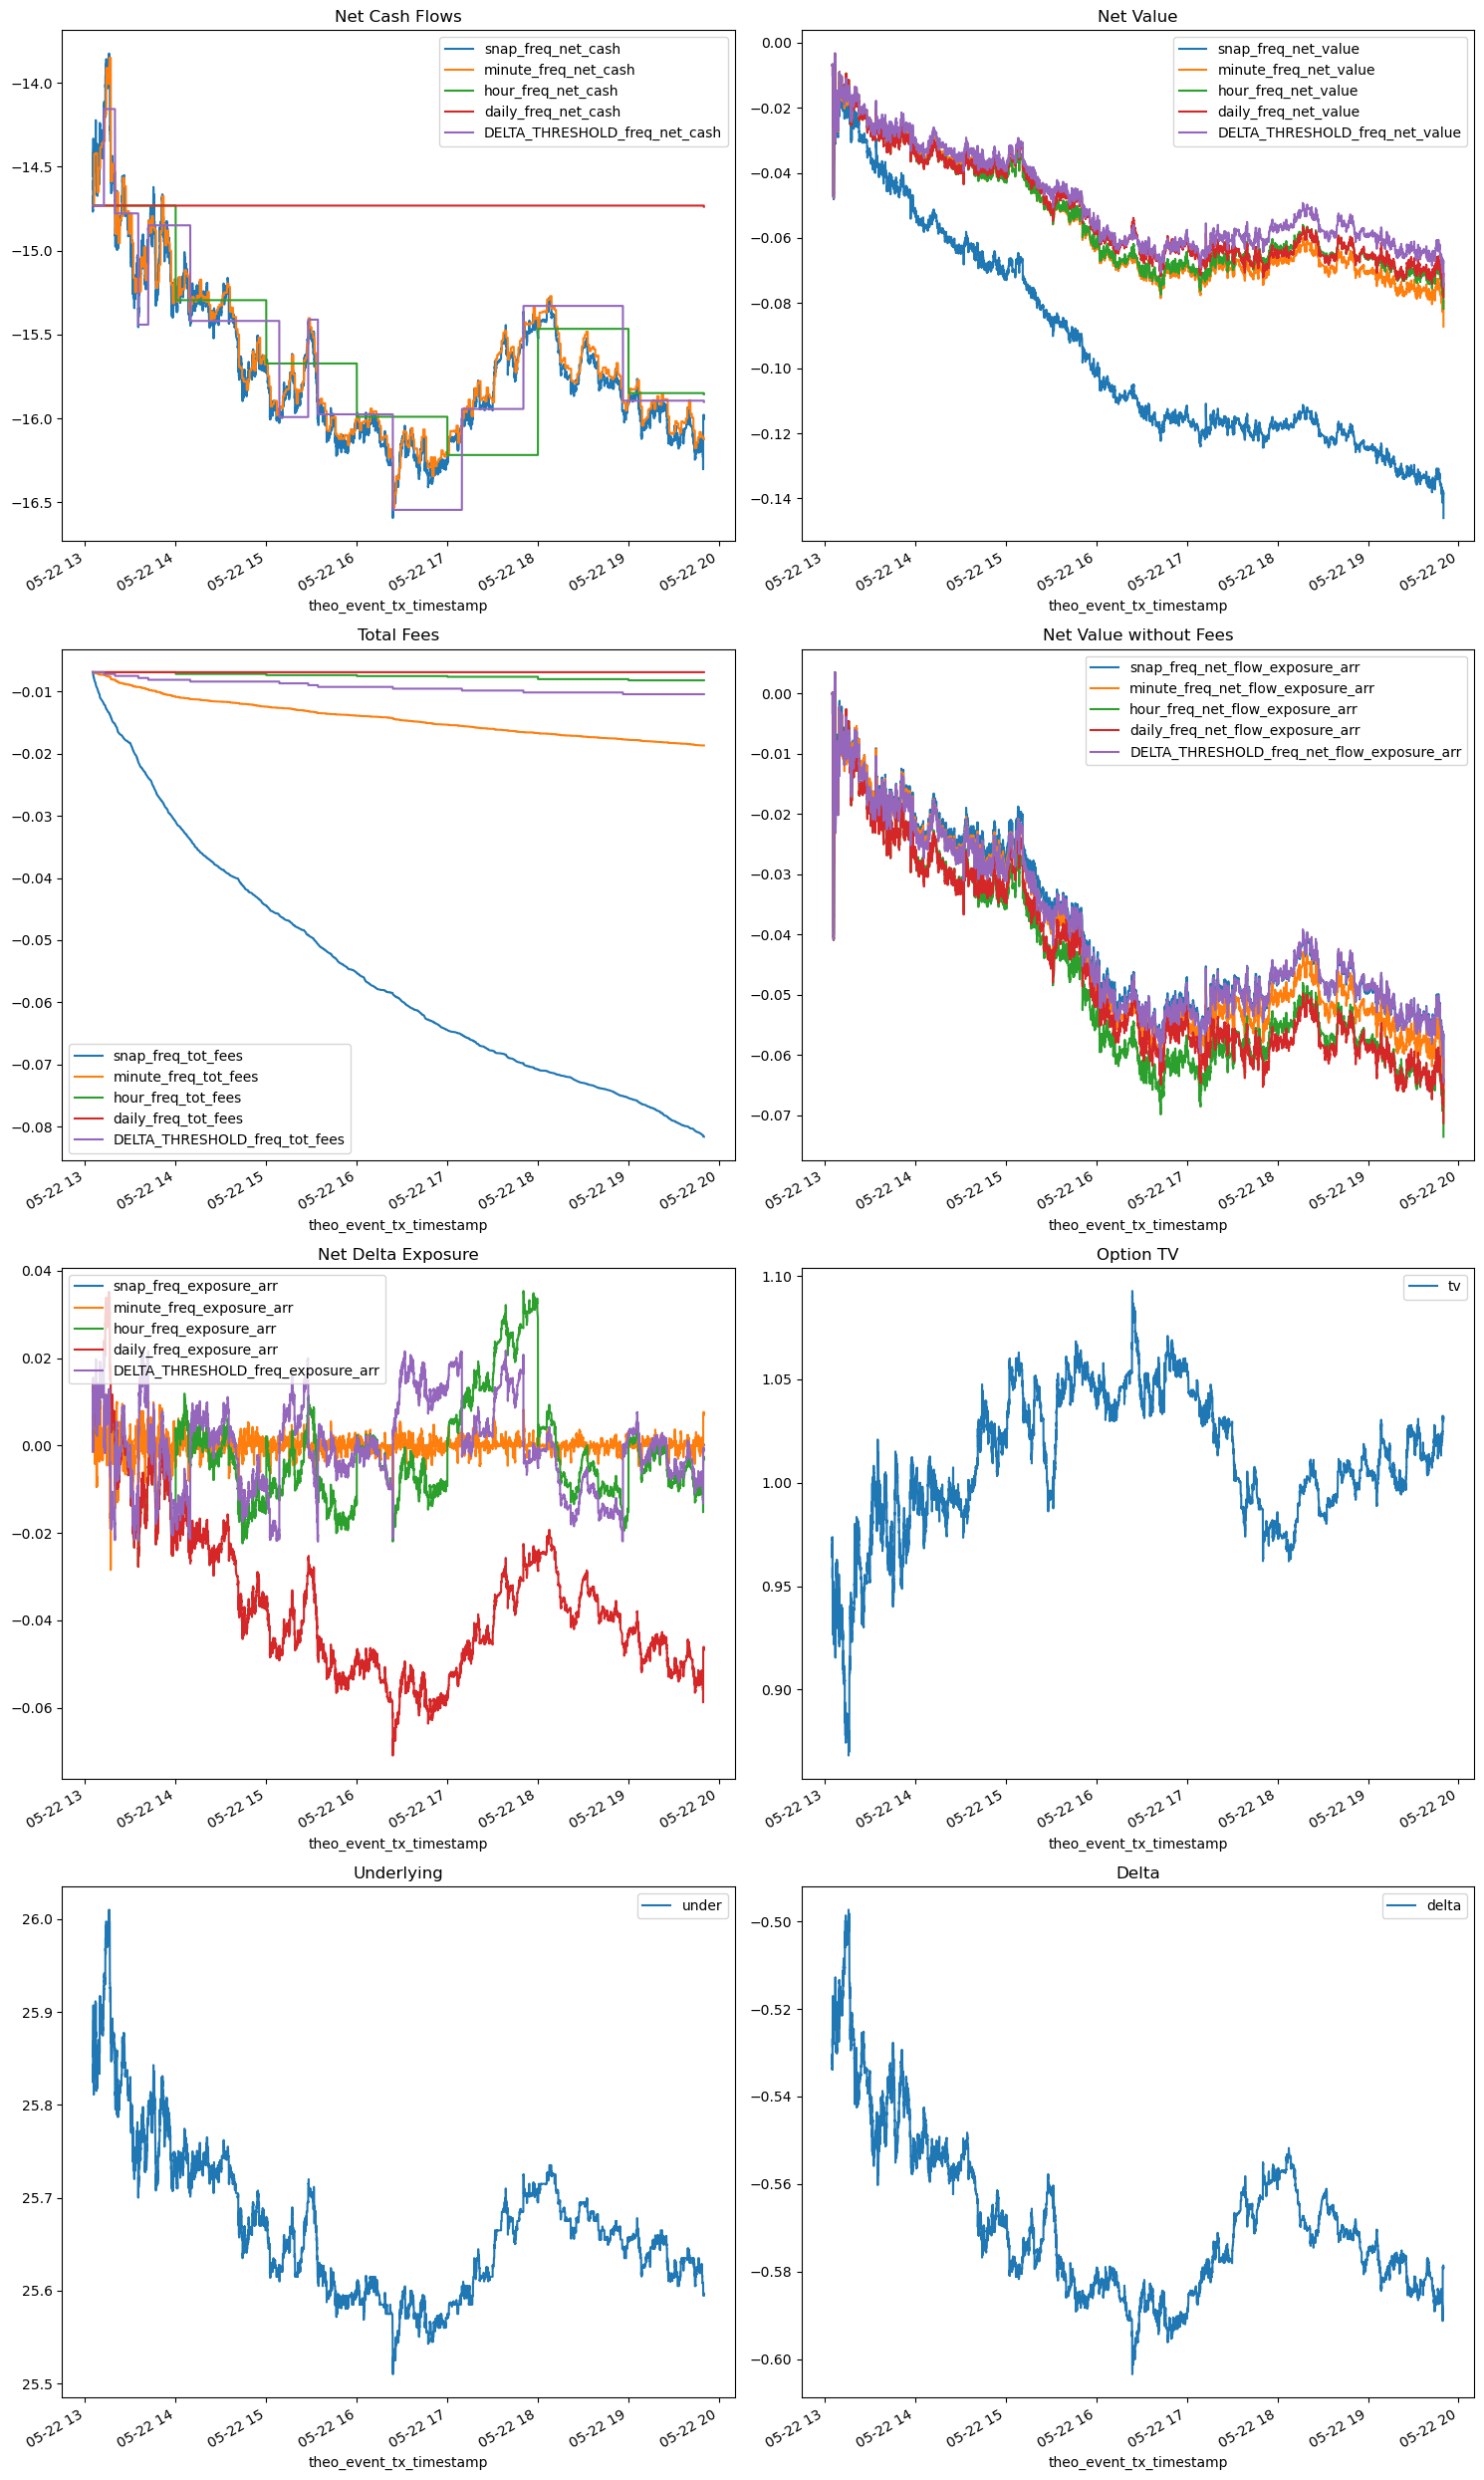

In [31]:
# Creating a figure with subplots arranged in 5 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(15, 25))

# Flatten the axs array for easy indexing
axs = axs.flatten()

# Plot 1: Frequency Net Cash
cls_22.data[['snap_freq_net_cash', 'minute_freq_net_cash', 
             'hour_freq_net_cash', 'daily_freq_net_cash', 
             'DELTA_THRESHOLD_freq_net_cash']].plot(ax=axs[0], title='Net Cash Flows')

# Plot 2: Frequency Net Value
cls_22.data[['snap_freq_net_value', 'minute_freq_net_value', 
             'hour_freq_net_value', 'daily_freq_net_value', 
             'DELTA_THRESHOLD_freq_net_value']].plot(ax=axs[1], title='Net Value')

# Plot 3: Frequency Total Fees
cls_22.data[['snap_freq_tot_fees', 'minute_freq_tot_fees', 
             'hour_freq_tot_fees', 'daily_freq_tot_fees', 
             'DELTA_THRESHOLD_freq_tot_fees']].plot(ax=axs[2], title='Total Fees')

# Plot 4: Frequency Net Flow Exposure
cls_22.data[['snap_freq_net_flow_exposure_arr', 'minute_freq_net_flow_exposure_arr', 
             'hour_freq_net_flow_exposure_arr', 'daily_freq_net_flow_exposure_arr', 
             'DELTA_THRESHOLD_freq_net_flow_exposure_arr']].plot(ax=axs[3], title='Net Value without Fees')

# Plot 5: Frequency Exposure
cls_22.data[['snap_freq_exposure_arr', 'minute_freq_exposure_arr', 
             'hour_freq_exposure_arr', 'daily_freq_exposure_arr', 
             'DELTA_THRESHOLD_freq_exposure_arr']].plot(ax=axs[4], title='Net Delta Exposure')

# Plot 6: TV
cls_22.data[['tv']].plot(ax=axs[5], title='Option TV')

# Plot 7: Underlying
cls_22.data[['under']].plot(ax=axs[6], title='Underlying')

# Plot 8: Delta
cls_22.data[['delta']].plot(ax=axs[7], title='Delta')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

## Day 23

In [32]:
cls_23 = Hedger(data=data_23)

In [33]:
cls_23.time_based_calculate(frequency=Frequency.SNAP)
cls_23.time_based_calculate(frequency=Frequency.MINUTE)
cls_23.time_based_calculate(frequency=Frequency.HOURLY)
cls_23.time_based_calculate(frequency=Frequency.DAILY)

In [34]:
cls_23.time_based_calculate(frequency=Frequency.DELTA_THRESHOLD, delta_threshold=delta_threshold)

In [35]:
#print out calculated data with header for debugging purposes
cls_23.data.head()

,theo_event_tx_timestamp,trade_date,option_type_name,term,strike,tv,delta,gamma,under,tte,...,daily_freq_net_value,daily_freq_tot_fees,daily_freq_net_flow_exposure_arr,daily_freq_exposure_arr,DELTA_THRESHOLD_freq_net_cash,DELTA_THRESHOLD_freq_MtM,DELTA_THRESHOLD_freq_net_value,DELTA_THRESHOLD_freq_tot_fees,DELTA_THRESHOLD_freq_net_flow_exposure_arr,DELTA_THRESHOLD_freq_exposure_arr
theo_event_tx_timestamp,,,,,,,,,,,,,,,,,,,,,
2023-05-23 13:05:00.140511,2023-05-23 13:05:00.140511,2023-05-23,PUT,Jun-2023,26.22,0.960491,-0.554694,0.219784,25.715,0.071222,...,-0.007132,-0.007132,3.295975e-16,0.000000,-15.231591,15.224459,-0.007132,-0.007132,3.295975e-16,0.000000
2023-05-23 13:05:00.292952,2023-05-23 13:05:00.292952,2023-05-23,PUT,Jun-2023,26.22,0.962184,-0.555298,0.219767,25.715,0.071222,...,-0.005440,-0.007132,1.692258e-03,-0.000603,-15.231591,15.226151,-0.005440,-0.007132,1.692258e-03,-0.000603
2023-05-23 13:05:00.659816,2023-05-23 13:05:00.659816,2023-05-23,PUT,Jun-2023,26.22,0.962174,-0.555214,0.219716,25.715,0.071222,...,-0.005450,-0.007132,1.682437e-03,-0.000519,-15.231591,15.226141,-0.005450,-0.007132,1.682437e-03,-0.000519
2023-05-23 13:05:00.811670,2023-05-23 13:05:00.811670,2023-05-23,PUT,Jun-2023,26.22,0.962994,-0.555506,0.219708,25.715,0.071222,...,-0.004629,-0.007132,2.503244e-03,-0.000812,-15.231591,15.226962,-0.004629,-0.007132,2.503244e-03,-0.000812
2023-05-23 13:05:01.141016,2023-05-23 13:05:01.141016,2023-05-23,PUT,Jun-2023,26.22,0.962988,-0.555464,0.219680,25.715,0.071222,...,-0.004635,-0.007132,2.496546e-03,-0.000769,-15.231591,15.226955,-0.004635,-0.007132,2.496546e-03,-0.000769


In [36]:
cls_23.data.shape

(57715, 43)

In [37]:
#just looking at the columns we want to plot
cls_23.data[['snap_freq_net_cash', 'minute_freq_net_cash', 'hour_freq_net_cash', 'daily_freq_net_cash', 'DELTA_THRESHOLD_freq_net_cash']].tail()

,snap_freq_net_cash,minute_freq_net_cash,hour_freq_net_cash,daily_freq_net_cash,DELTA_THRESHOLD_freq_net_cash
theo_event_tx_timestamp,,,,,
2023-05-23 19:49:58.375220,-12.577795,-11.855652,-12.365796,-15.231591,-12.486459
2023-05-23 19:49:58.707187,-12.577660,-11.855652,-12.365796,-15.231591,-12.486459
2023-05-23 19:49:59.317386,-12.577694,-11.855652,-12.365796,-15.231591,-12.486459
2023-05-23 19:49:59.484882,-12.581811,-11.855652,-12.365796,-15.231591,-12.486459
2023-05-23 19:49:59.706294,-12.587721,-11.861243,-12.371649,-15.238888,-12.492374


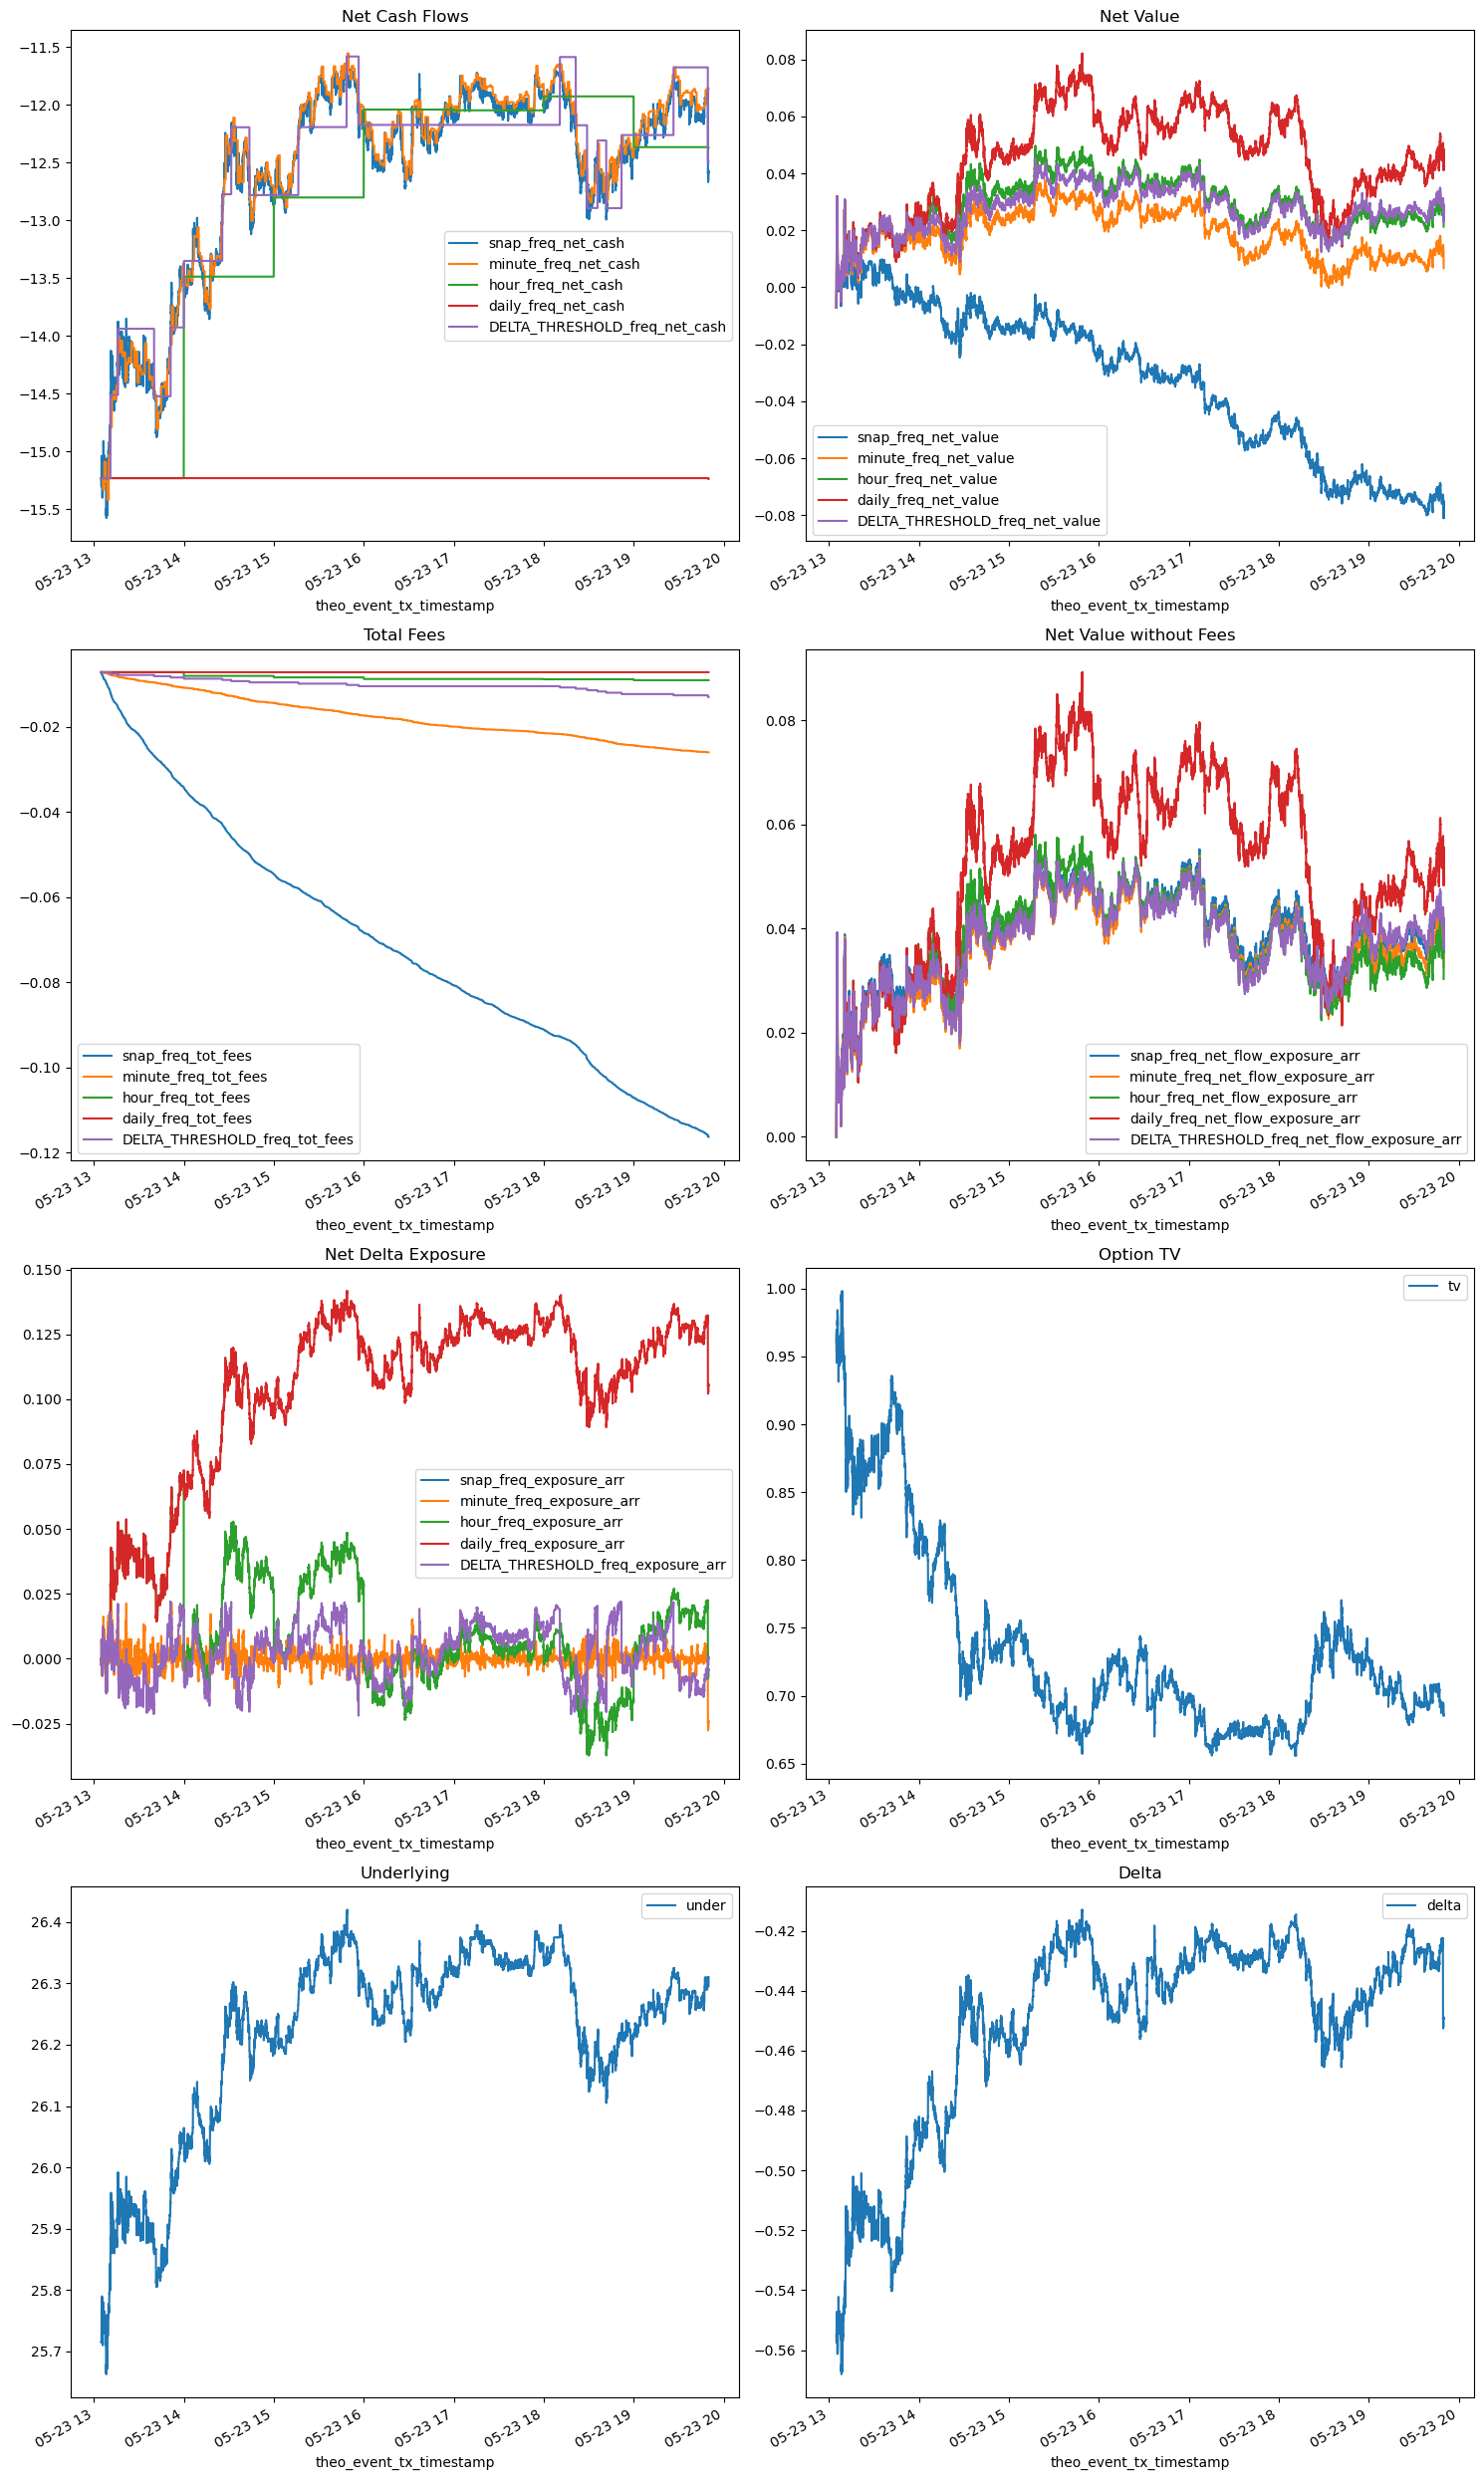

In [38]:
# Creating a figure with subplots arranged in 5 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(15, 25))

# Flatten the axs array for easy indexing
axs = axs.flatten()

# Plot 1: Frequency Net Cash
cls_23.data[['snap_freq_net_cash', 'minute_freq_net_cash', 
             'hour_freq_net_cash', 'daily_freq_net_cash', 
             'DELTA_THRESHOLD_freq_net_cash']].plot(ax=axs[0], title='Net Cash Flows')

# Plot 2: Frequency Net Value
cls_23.data[['snap_freq_net_value', 'minute_freq_net_value', 
             'hour_freq_net_value', 'daily_freq_net_value', 
             'DELTA_THRESHOLD_freq_net_value']].plot(ax=axs[1], title='Net Value')

# Plot 3: Frequency Total Fees
cls_23.data[['snap_freq_tot_fees', 'minute_freq_tot_fees', 
             'hour_freq_tot_fees', 'daily_freq_tot_fees', 
             'DELTA_THRESHOLD_freq_tot_fees']].plot(ax=axs[2], title='Total Fees')

# Plot 4: Frequency Net Flow Exposure
cls_23.data[['snap_freq_net_flow_exposure_arr', 'minute_freq_net_flow_exposure_arr', 
             'hour_freq_net_flow_exposure_arr', 'daily_freq_net_flow_exposure_arr', 
             'DELTA_THRESHOLD_freq_net_flow_exposure_arr']].plot(ax=axs[3], title='Net Value without Fees')

# Plot 5: Frequency Exposure
cls_23.data[['snap_freq_exposure_arr', 'minute_freq_exposure_arr', 
             'hour_freq_exposure_arr', 'daily_freq_exposure_arr', 
             'DELTA_THRESHOLD_freq_exposure_arr']].plot(ax=axs[4], title='Net Delta Exposure')

# Plot 6: TV
cls_23.data[['tv']].plot(ax=axs[5], title='Option TV')

# Plot 7: Underlying
cls_23.data[['under']].plot(ax=axs[6], title='Underlying')

# Plot 8: Delta
cls_23.data[['delta']].plot(ax=axs[7], title='Delta')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

### Analysis of Strategy Performance Based on Daily Frequency
#### Observing that the daily frequency yields the highest P&L from all regular frequencies (and beating the delta threshold strategy on day 23), we need to evaluate this result by considering two theoretical scenarios.

### Scenario 1: Decreasing Underlying Price
#### When the underlying price decreases consistently throughout the period:
- The delta decreases (in absolute value, delta increases), which means we would be buying a positive amount of the underlying asset at the final snap, equal to the difference between the initial delta and the final delta.
- Because we purchase the underlying asset at its lowest price within the observed period, the daily frequency strategy yields the highest PnL. 
- Other strategies, which require adjusting the hedge more frequently, will buy the underlying at higher average prices, making it impossible to achieve a higher PnL than the daily strategy, provided we must be fully delta-hedged at both the first and last snap.

### Scenario 2: Increasing Underlying Price
#### When the underlying price increases consistently throughout the period:
- The delta increases (in absolute value, delta decreases), which leads to selling a positive amount of the underlying asset at the final snap, again equal to the difference between the initial delta and the final delta.
- This selling occurs at the highest price observed during the period, ensuring that the daily frequency strategy again maximizes PnL.
- As with the first scenario, no other strategy can outperform the daily frequency adjustment under the constraint of being fully delta-hedged at the first and last snaps.

### Thoughts
#### In cases where the underlying price only increases or only decreases, no strategy can outperform the daily delta-hedging strategy, assuming we are confined to fully delta-hedging during the first and last snaps, and considering only one day of data. However, if the underlying price fluctuates—both increasing and decreasing—other strategies may outperform daily hedging. Furthermore, it is worth exploring strategies that do not require full delta-hedging at the first snap, while still ensuring full delta-hedging at the last snap.

#### For the purpose of optimisation of of the constant frequency strategies, we will experiment with the following strategy: During the first snap and every m hours, we hedge a portion p of the delta (The method is already incoporated in the Hedger class via the function fractional_time_based_calculate). Note that the fractional hedge hedges once every m hours, starting from the first snap and fully hedges at the last snap. The hourly hedge for example, hedges at every whole hour, hence why there are minor differences between hourly hedge and fractional hedge with p = 1 and m = 1.

In [39]:
# First a sanity check to make sure that the result for p = 1, m = 24 is equivalent to daily hedge
cls_22.fractional_time_based_calculate(p=1, m=24)
cls_22.data[['snap_freq_net_value', 'minute_freq_net_value', 'hour_freq_net_value', 'daily_freq_net_value', 'fractional_freq_net_value']]

,snap_freq_net_value,minute_freq_net_value,hour_freq_net_value,daily_freq_net_value,fractional_freq_net_value
theo_event_tx_timestamp,,,,,
2023-05-22 13:05:00.294344,-0.006878,-0.006878,-0.006878,-0.006878,-0.006878
2023-05-22 13:05:00.491156,-0.006892,-0.006864,-0.006864,-0.006864,-0.006864
2023-05-22 13:05:00.709865,-0.006902,-0.006874,-0.006874,-0.006874,-0.006874
2023-05-22 13:05:01.196496,-0.006906,-0.006877,-0.006877,-0.006877,-0.006877
2023-05-22 13:05:01.351634,-0.006906,-0.006877,-0.006877,-0.006877,-0.006877
...,...,...,...,...,...
2023-05-22 19:49:57.748406,-0.138073,-0.079163,-0.073823,-0.070798,-0.070798
2023-05-22 19:49:58.477191,-0.138073,-0.079163,-0.073823,-0.070798,-0.070798
2023-05-22 19:49:58.747898,-0.138066,-0.079156,-0.073816,-0.070791,-0.070791


#### Next, we tune the fractional hedge by examining a small set of possible values for p and m and checking which provides the highest net value. Note that we do not consider values of p > 1. While p > 1 will be a very profitable strategy for situations where the underlying price increases, it does not make sense to over-hedge the position, as we are incurring extra transaction costs. As market makers, we do not bet on delta.

In [40]:
# Define the values for p and m
p_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
m_values = [0.2, 0.5, 1.5, 3, 24]  # m = 24, p = 1 would be equivalent to daily hedge

results = []


best_net_value = -np.inf
best_p = None
best_m = None



for p in p_values:
    for m in m_values:
        
        cls_22.fractional_time_based_calculate(p=p, m=m)
        
        
        final_net_value = cls_22.data['fractional_freq_net_value'].iloc[-1]
        
       
        results.append({'p': p, 'm': m, 'net_value': final_net_value})
        
        # Check if this is the best net value found so far
        if final_net_value > best_net_value:
            best_net_value = final_net_value
            best_p = p
            best_m = m


results_df = pd.DataFrame(results)

print(f"Best p: {best_p}, Best m: {best_m}, Best Net Value: {best_net_value}")

print(results_df)

Best p: 0.1, Best m: 24, Best Net Value: 0.04758618127683434
      p     m  net_value
0   0.1   0.2  -0.023972
1   0.1   0.5   0.008538
2   0.1   1.5   0.030418
3   0.1   3.0   0.042221
4   0.1  24.0   0.047586
5   0.3   0.2  -0.067743
6   0.3   0.5  -0.033094
7   0.3   1.5  -0.012511
8   0.3   3.0   0.009130
9   0.3  24.0   0.019644
10  0.5   0.2  -0.081721
11  0.5   0.5  -0.055140
12  0.5   1.5  -0.040444
13  0.5   3.0  -0.018448
14  0.5  24.0  -0.008298
15  0.7   0.2  -0.086161
16  0.7   0.5  -0.068688
17  0.7   1.5  -0.060689
18  0.7   3.0  -0.042828
19  0.7  24.0  -0.036240
20  0.9   0.2  -0.085351
21  0.9   0.5  -0.078668
22  0.9   1.5  -0.076041
23  0.9   3.0  -0.066327
24  0.9  24.0  -0.064182
25  1.0   0.2  -0.083677
26  1.0   0.5  -0.083202
27  1.0   1.5  -0.081693
28  1.0   3.0  -0.078680
29  1.0  24.0  -0.078153


#### We obtain p = 0.1, m = 3. Note that low values for p will offer higher net value for decreasing undlerying price and high values of p offer a higher net value for increasing underlying price. Since 22nd May has a generally decreasing price of the underlying, we get higher net value for lower p. This does not mean lower p is better in general.

#### Next, we try a similar model, but this time we fully hedge at the first snap, and then we hedge a fraction p every m hours. Again we fully hedge at the last snap.

In [41]:
# Another sanity check - m = 24 should always give equivalent results to daily hedge
cls_22.full_then_fractional_time_based_calculate(p=0.5, m=24)
cls_22.data[['snap_freq_net_value', 'minute_freq_net_value', 'hour_freq_net_value', 'daily_freq_net_value', 'fractional_freq_net_value', 'full_then_fractional_freq_net_value']]

,snap_freq_net_value,minute_freq_net_value,hour_freq_net_value,daily_freq_net_value,fractional_freq_net_value,full_then_fractional_freq_net_value
theo_event_tx_timestamp,,,,,,
2023-05-22 13:05:00.294344,-0.006878,-0.006878,-0.006878,-0.006878,-0.006878,-0.006878
2023-05-22 13:05:00.491156,-0.006892,-0.006864,-0.006864,-0.006864,-0.006864,-0.006864
2023-05-22 13:05:00.709865,-0.006902,-0.006874,-0.006874,-0.006874,-0.006874,-0.006874
2023-05-22 13:05:01.196496,-0.006906,-0.006877,-0.006877,-0.006877,-0.006877,-0.006877
2023-05-22 13:05:01.351634,-0.006906,-0.006877,-0.006877,-0.006877,-0.006877,-0.006877
...,...,...,...,...,...,...
2023-05-22 19:49:57.748406,-0.138073,-0.079163,-0.073823,-0.070798,-0.070798,-0.070798
2023-05-22 19:49:58.477191,-0.138073,-0.079163,-0.073823,-0.070798,-0.070798,-0.070798
2023-05-22 19:49:58.747898,-0.138066,-0.079156,-0.073816,-0.070791,-0.070791,-0.070791


In [42]:
p_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
m_values = [0.2, 0.5, 1.5, 3, 24]  # m = 24 would be equivalent to daily hedge

results = []

best_net_value = -np.inf
best_p = None
best_m = None


for p in p_values:
    for m in m_values: 
        cls_22.full_then_fractional_time_based_calculate(p=p, m=m)
         
        final_net_value = cls_22.data['full_then_fractional_freq_net_value'].iloc[-1]     
        
        results.append({'p': p, 'm': m, 'net_value': final_net_value})
        
        if final_net_value > best_net_value:
            best_net_value = final_net_value
            best_p = p
            best_m = m

results_df = pd.DataFrame(results)
print(f"Best p: {best_p}, Best m: {best_m}, Best Net Value: {best_net_value}")
print(results_df)

Best p: 0.1, Best m: 24, Best Net Value: -0.07815304584669747
      p     m  net_value
0   0.1   0.2  -0.080711
1   0.1   0.5  -0.080148
2   0.1   1.5  -0.079135
3   0.1   3.0  -0.078591
4   0.1  24.0  -0.078153
5   0.3   0.2  -0.081818
6   0.3   0.5  -0.081054
7   0.3   1.5  -0.080344
8   0.3   3.0  -0.079196
9   0.3  24.0  -0.078153
10  0.5   0.2  -0.082676
11  0.5   0.5  -0.081635
12  0.5   1.5  -0.080875
13  0.5   3.0  -0.079439
14  0.5  24.0  -0.078153
15  0.7   0.2  -0.083170
16  0.7   0.5  -0.082306
17  0.7   1.5  -0.081156
18  0.7   3.0  -0.079322
19  0.7  24.0  -0.078153
20  0.9   0.2  -0.083518
21  0.9   0.5  -0.082909
22  0.9   1.5  -0.081477
23  0.9   3.0  -0.078918
24  0.9  24.0  -0.078153
25  1.0   0.2  -0.083677
26  1.0   0.5  -0.083202
27  1.0   1.5  -0.081693
28  1.0   3.0  -0.078680
29  1.0  24.0  -0.078153


#### This delta hedging strategy is much less sensitive to the choice of values for p and m, as we are forced to fully hedge at the first snap. We cannot fine-tune well with this dataset. Let's examine the testing dataset and present our conclusion for these two partial hedging strategies.

In [ ]:
cls_23.fractional_time_based_calculate(p=0.1, m=3)
cls_23.full_then_fractional_time_based_calculate(p=1, m=3)
cls_23.data[['snap_freq_net_value', 'minute_freq_net_value', 'hour_freq_net_value', 'daily_freq_net_value', 'fractional_freq_net_value', 'full_then_fractional_freq_net_value']]

#### As explained before, when using fractional_freq_net_value the best value of p greatly depends on whether the underlying is increasing/decreasing. Since we do not know what will be the case, we should pick a middle-ground p such as p = 0.5. The full_then_fractional_freq_net_value managed to beat all the 4 main benchmarks for both the datasets for p=1, m=3.

In [ ]:
cls_23.fractional_time_based_calculate(p=0.5, m=3)
cls_23.data[['snap_freq_net_value', 'minute_freq_net_value', 'hour_freq_net_value', 'daily_freq_net_value', 'fractional_freq_net_value', 'full_then_fractional_freq_net_value']]

#### The two datasets are both primarily decreasing (22nd May dataset) and primarily increasing (23rd May dataset) in the underlying. We lack the situation where there is high volatility but the final price does not change much. Without more datasets, we cannot fine tune the algorithms futrther. However, we present a rule of thumb for selecting p and m:

- Underlying price decreases - Use the fractional_freq_net_value for low p
- Underlying price increases - Use the fractional_freq_net_value for high p
- High volatility - decrease m

#### While we have found a hedging strategy that outperforms the daily hedge for both datasets, it is clear that this strategy is not robust. We present a more robust approach - the Delta Threshold approach that was introduced earlier:

## Testing performance on different delta thresholds

In [ ]:
# Define a range of delta thresholds to test around 0.025
delta_thresholds = np.linspace(0.01, 0.04, 11)

# Store net values for each delta threshold for both days 22 and 23
net_values_day_22 = []
net_values_day_23 = []

# Day 22
cls_22 = Hedger(data=data_22)
for threshold in delta_thresholds:
    cls_22.time_based_calculate(frequency=Frequency.DELTA_THRESHOLD, delta_threshold=threshold)
    net_value = cls_22.data['DELTA_THRESHOLD_freq_net_value'].iloc[-1]  # Last value of net value
    net_values_day_22.append(net_value)

# Day 23
cls_23 = Hedger(data=data_23)
for threshold in delta_thresholds:
    cls_23.time_based_calculate(frequency=Frequency.DELTA_THRESHOLD, delta_threshold=threshold)
    net_value = cls_23.data['DELTA_THRESHOLD_freq_net_value'].iloc[-1]  # Last value of net value
    net_values_day_23.append(net_value)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(delta_thresholds, net_values_day_22, label='Day 22 Net Value', marker='o')
plt.plot(delta_thresholds, net_values_day_23, label='Day 23 Net Value', marker='o')
plt.xlabel('Delta Threshold')
plt.ylabel('Net Value')
plt.title('Net Value vs Delta Threshold')
plt.legend()
plt.grid(True)
plt.show()


## Conclusions

- As observed from the last chart, the resulting P&L relative to the chosen delta threshold is neither smooth nor predictable. Although a threshold of 0.022 seems to yield the best average results for between day 22 and day 23, it carries a higher risk at any given time compared to a lower threshold.

- **Frequent Hedging**: Frequent hedging incurs higher fees and increases liquidity risk, which can reduce P&L in a unidirectional market due to continuous buying and selling, leading to fees and potential losses. However, it allows for the capitalization on opportunities when market conditions are favorable.

- **Infrequent Hedging**: Infrequent hedging exposes the portfolio to greater directional risk because of large variances in delta exposure. This approach may fail to capture profits in a sideways, oscillating market—where the advantages of frequent hedging likely outweigh the associated transaction costs.

- **Delta Threshold Extremes**: In the limit, as $\delta \text{ threshold} \rightarrow 0$, hedging occurs at every snap, while as $\delta \text{ threshold} \rightarrow 1$, hedging is done at the end of the day. The goal should be to find a balance between P&L and delta risk that is effective across a range of market conditions.

- **Hedging at Equidistant Intervals**: Hedging at fixed intervals is overly simplistic, as it does not generalize well across diverse market conditions. For example, this approach might miss significant market swings that return to the same level, thereby missing out on potential profits.

- **Risk Preferences**: Risk preferences vary among individuals. For this analysis, we consider them arbitrary. However, a lower delta threshold that still performs reasonably well may be desirable due to the enhanced delta neutrality and reduced risk it provides.

- **Gamma and Vega**: We are not using gamma or vega as measures for hedging frequency in this exercise (e.g., hedging more frequently with higher gamma) because we assume the market’s direction cannot be predicted—whether it oscillates (which is beneficial) or trends strongly (which is detrimental)—as both scenarios can involve high gamma and vega. Additional data would be necessary to support any empirical claims.

- **Potential for More Complex Strategies**: There is potential for more sophisticated strategies, including those that do not aim to hedge to a net-zero delta each time. However, such strategies would require some predictive insight into delta movements. For this exercise, we assume no foresight into market direction. Predicting market movements is inherently difficult, even with advanced metrics like implied volatility derived from the Black-Scholes model. However, with adaptive delta hedging, we can confidently capture profits in favorable conditions while limiting losses in less favorable ones.